In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

#set path where to read and write data
data_path = "C:/Users/adiad/Anaconda3/envs/BasicDataScience/Projects/titanic/"

#import data
train_df = pd.read_csv(os.path.join(data_path, "train.csv"), index_col=0)
test_df = pd.read_csv(os.path.join(data_path, "test.csv"), index_col=0)

# Titanic Survival - Kaggle Competition

By Chris Raper

## Introduction

This notebook is my first data science project with Python after completing the the Data Science with Python career track on DataCamp.  This work was competed without any reference to Titanic dataset tutorials.  The notebook begins with data cleaning, feature engineering and transforming the data into machine learning format.  Then models are built using decision tree classifiers and random forest ensemble techniques along with hyperparameter tuning via random search.

## Data Wrangling

The following code cells will examine the training data and wrangle it into a more usable form.  All the operations performed on the training dataset will also be performed on test dataset so the trained models can operate on the test dataset.

In [3]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


The Pclass, Sex and Embarked features should be converted to Pandas Categorical dtype.  Converting Survived to a category would hinder aggregation calculations during EDA, therefore it will not be converted.

In [5]:
#converting objects data types into categorical types
train_df["Pclass"] = pd.Categorical(train_df["Pclass"], categories=[1,2,3], ordered=True)
train_df["Sex"] = pd.Categorical(train_df["Sex"], categories=["male", "female"], ordered=False)
train_df["Embarked"] = pd.Categorical(train_df["Embarked"], categories=["C", "Q", "S"], ordered=False)
test_df["Pclass"] = pd.Categorical(test_df["Pclass"], categories=[1,2,3], ordered=True)
test_df["Sex"] = pd.Categorical(test_df["Sex"], categories=["male", "female"], ordered=False)
test_df["Embarked"] = pd.Categorical(test_df["Embarked"], categories=["C", "Q", "S"], ordered=False)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null category
Name        891 non-null object
Sex         891 non-null category
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null category
dtypes: category(3), float64(2), int64(3), object(3)
memory usage: 65.6+ KB


Next, attention will be paid to dividing the Name feature into more useful variables.

In [6]:
train_df.Name.head(50)

PassengerId
1                               Braund, Mr. Owen Harris
2     Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                Heikkinen, Miss. Laina
4          Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                              Allen, Mr. William Henry
6                                      Moran, Mr. James
7                               McCarthy, Mr. Timothy J
8                        Palsson, Master. Gosta Leonard
9     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
10                  Nasser, Mrs. Nicholas (Adele Achem)
11                      Sandstrom, Miss. Marguerite Rut
12                             Bonnell, Miss. Elizabeth
13                       Saundercock, Mr. William Henry
14                          Andersson, Mr. Anders Johan
15                 Vestrom, Miss. Hulda Amanda Adolfina
16                     Hewlett, Mrs. (Mary D Kingcome) 
17                                 Rice, Master. Eugene
18                         Williams,

This shows the Name strings follow a pattern: LastName, Title. FirstName.  In addition, some names have another name appended in parantheses, and some names apparently have a nickname appeneded in double quotes.  The first step to wrangle this data will be splitting the name feature into separate Last, Title & First features.

In [7]:
#extract beginning of string until comma is found
train_df["LastName"] = train_df.Name.str.extract("([^,]+)", expand=True)
test_df["LastName"] = test_df.Name.str.extract("([^,]+)", expand=True)

#extract beginning after the comma and ending at the period
train_df["Title"] = train_df.Name.str.extract(r", (.*?)\.", expand=True)
train_df["Title"] = pd.Categorical(train_df["Title"],
                                    categories=train_df.Title.unique(),
                                    ordered=False)
test_df["Title"] = test_df.Name.str.extract(r", (.*?)\.", expand=True)
test_df["Title"] = pd.Categorical(test_df["Title"],
                                    categories=test_df.Title.unique(),
                                    ordered=False)

#extract all text following the title word
train_df["FirstName"] = train_df.Name.str.extract(r"\. (.*?)$", expand=True)
test_df["FirstName"] = test_df.Name.str.extract(r"\. (.*?)$", expand=True)

#drop the original Name field since its information is now fully duplicated by the new fields.
train_df = train_df.drop("Name", axis=1)
test_df = test_df.drop("Name", axis=1)

train_df.loc[:,["LastName", "Title", "FirstName"]].head(50)

,LastName,Title,FirstName
PassengerId,,,
1,Braund,Mr,Owen Harris
2,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
3,Heikkinen,Miss,Laina
4,Futrelle,Mrs,Jacques Heath (Lily May Peel)
5,Allen,Mr,William Henry
6,Moran,Mr,James
7,McCarthy,Mr,Timothy J
8,Palsson,Master,Gosta Leonard
9,Johnson,Mrs,Oscar W (Elisabeth Vilhelmina Berg)


The FirstName variable still needs cleaning (dropping the "nickname" substrings and splitting the (Associate Name) substring into a separate field.  But this information isn't expected to add value, therefore it will be ignored.

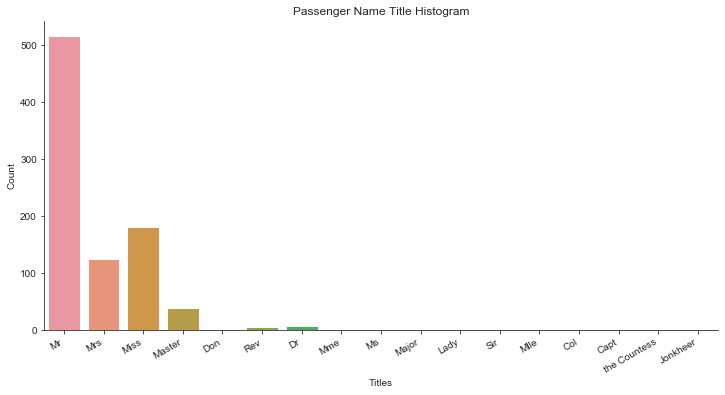

In [8]:
sns.set_style("ticks")
sns.catplot(x="Title", kind="count", data=train_df, aspect=2)
plt.xlabel("Titles")
plt.ylabel("Count")
plt.title("Passenger Name Title Histogram")
plt.xticks(rotation=30, ha='right')
plt.show()

Studying the Ticket and Cabin features shows they would benefit from cleaning.  However, it isn't obvious how to proceed without researching the meaning of these features.  For now, they will be ignored.

Lastly, if Age is greater than 1 and has a fraction of 0.5, then age is an estimate rather than exact.  This feature will be caputred by a new boolean feature AgeIsExact.

C:\Users\adiad\Anaconda3\envs\BasicDataScience\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\adiad\Anaconda3\envs\BasicDataScience\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


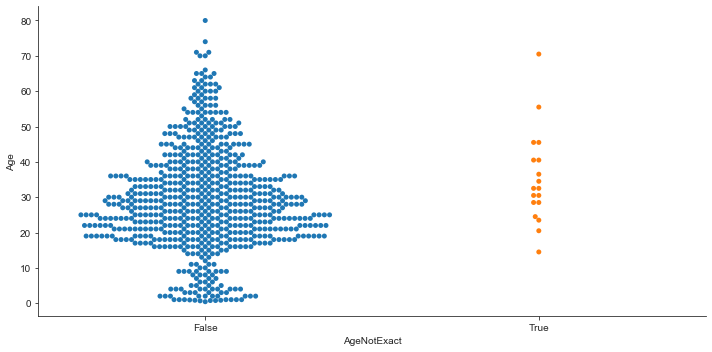

In [9]:
train_df["AgeNotExact"] = np.where((train_df["Age"] > 1) & (round(train_df["Age"]) != train_df["Age"]), True, False)
train_df["AgeNotExact"] = pd.Categorical(train_df["AgeNotExact"], categories=[False, True], ordered=False)
test_df["AgeNotExact"] = np.where((test_df["Age"] > 1) & (round(test_df["Age"]) != test_df["Age"]), True, False)
test_df["AgeNotExact"] = pd.Categorical(test_df["AgeNotExact"], categories=[False, True], ordered=False)

sns.catplot(x='AgeNotExact', y='Age', data=train_df, kind='swarm', orient='v', aspect=2)
plt.show()

Since the Passenger ID, Ticket and Cabin features are not intended for modeling liklihood of survival, these field will be dropped from the data frame.  Also the FirstName and LastName features will be dropped since language processing techniques will not be applied in the model.

In [10]:
train_df = train_df.drop(["Ticket", "Cabin", "FirstName", "LastName"], axis=1)
test_df = test_df.drop(["Ticket", "Cabin", "FirstName", "LastName"], axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
Survived       891 non-null int64
Pclass         891 non-null category
Sex            891 non-null category
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null category
Title          891 non-null category
AgeNotExact    891 non-null category
dtypes: category(5), float64(2), int64(3)
memory usage: 87.3 KB


Lastly, the data needs to be transformed for machine learning.  The table printed above shows that only the Age and Embarked features have missing values.  This will be resolved by the common practice of imputing the median Age and the most frequent Embark location wherever missing values are encountered.  Categorical features will be transformed using OneHotEncoder.


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#create a pipeline for transforming numeric variables
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encode', OneHotEncoder())
])

#create lists which define the numeric and categorical variables
num_attr = ["Age", "SibSp", "Parch", "Fare"]
cat_attr = ["Pclass", "Sex", "Embarked", "AgeNotExact"]

#get names of categorical variables after OneHotEncoder
cat_encode_attr = OneHotEncoder().fit(train_df[cat_attr].dropna()).get_feature_names(cat_attr).tolist()

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attr),
    ("cat", cat_pipeline, cat_attr)
])

y_train = train_df["Survived"]
prepped_X_train = full_pipeline.fit_transform(train_df.drop("Survived", axis=1))
prepped_X_test = full_pipeline.fit_transform(test_df)

##Exploratory Data Analysis

The following code cells will explore how the features affect the target (survival) in preparation for building models.

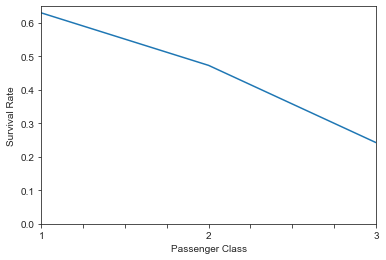

In [12]:
pclass_agg = train_df.groupby("Pclass")["Survived"].agg("mean")
pclass_agg.plot(x=pclass_agg.index, y="Survived")
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.ylim(bottom=0)
plt.show()

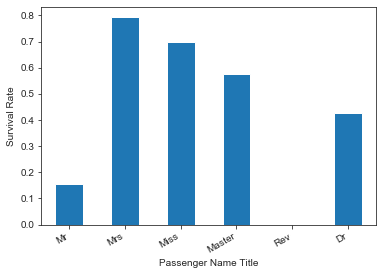

In [13]:
title_filter_agg = train_df.groupby("Title")["Survived"].agg("count")
title_filter = title_filter_agg > 5 #acts as a boolean filter to drop groups with small samples
title_agg = train_df.groupby("Title")["Survived"].agg("mean")
title_agg = title_agg[title_filter]
title_agg.plot.bar(x=title_agg.index, y="Survived")
plt.xlabel("Passenger Name Title")
plt.xticks(rotation=30, ha='right')
plt.ylabel("Survival Rate")
plt.ylim(bottom=0)
plt.show()

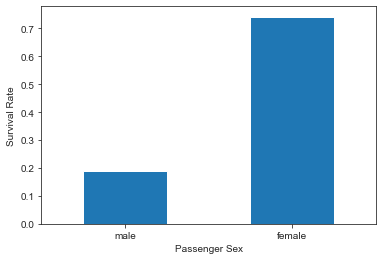

In [14]:
sex_agg = train_df.groupby("Sex")["Survived"].agg("mean")
sex_agg.plot.bar(x=sex_agg.index, y="Survived")
plt.xlabel("Passenger Sex")
plt.xticks(rotation=0, ha='center')
plt.ylabel("Survival Rate")
plt.ylim(bottom=0)
plt.show()

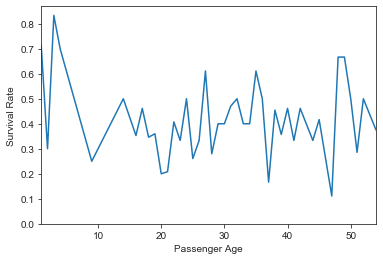

In [15]:
age_filter_agg = train_df.groupby("Age")["Survived"].agg("count")
age_filter = age_filter_agg > 5 #acts as a boolean filter to drop groups with small samples
age_agg = train_df.groupby("Age")["Survived"].agg("mean")
age_agg = age_agg[age_filter]
age_agg.plot(x=age_agg.index, y="Survived")
plt.xlabel("Passenger Age")
plt.ylabel("Survival Rate")
plt.ylim(bottom=0)
plt.show()

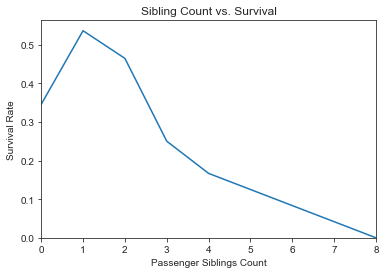

In [17]:
sibs_filter_agg = train_df.groupby("SibSp")["Survived"].agg("count")
sibs_filter = sibs_filter_agg > 5 #acts as a boolean filter to drop groups with small samples
sibs_agg = train_df.groupby("SibSp")["Survived"].agg("mean")
sibs_agg = sibs_agg[sibs_filter]
sibs_agg.plot(x=sibs_agg.index, y="Survived")
plt.title("Sibling Count vs. Survival")
plt.xlabel("Passenger Siblings Count")
plt.ylabel("Survival Rate")
plt.ylim(bottom=0)
plt.savefig(os.path.join(data_path, "Siblings-vs-Survival.png"), dpi=100)
plt.show()

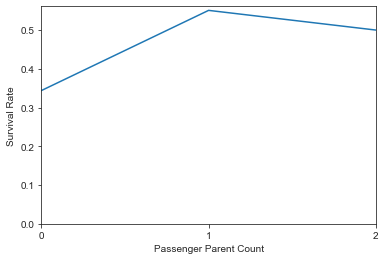

In [16]:
parch_filter_agg = train_df.groupby("Parch")["Survived"].agg("count")
parch_filter = parch_filter_agg > 5 #acts as a boolean filter to drop groups with small samples
parch_agg = train_df.groupby("Parch")["Survived"].agg("mean")
parch_agg = parch_agg[parch_filter]
parch_agg.plot(x=parch_agg.index, y="Survived")
plt.xlabel("Passenger Parent Count")
plt.xticks(ticks=[0,1,2])
plt.ylabel("Survival Rate")
plt.ylim(bottom=0)
plt.show()

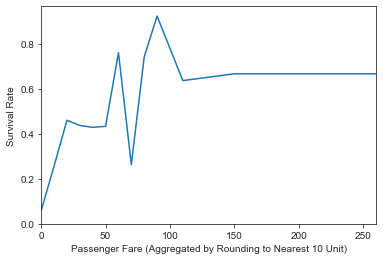

In [17]:
train_df["RndFare"] = round(train_df["Fare"], -1)
fare_filter_agg = train_df.groupby("RndFare")["Survived"].agg("count")
fare_filter = fare_filter_agg > 5 #acts as a boolean filter to drop groups with small samples
fare_agg = train_df.groupby("RndFare")["Survived"].agg("mean")
fare_agg = fare_agg[fare_filter]
fare_agg.plot(x=fare_agg.index, y="Survived")
plt.xlabel("Passenger Fare (Aggregated by Rounding to Nearest 10 Unit)")
plt.ylabel("Survival Rate")
plt.ylim(bottom=0)
plt.show()

A few surpising results were produced above.  First, age has little correlation with survival rate.  Also, having increasingly more than 1 sibling has negative correlation with survival rate.  Perhaps this is an inidcator of class or wealth, or was caused by searching for family members thereby hurting survival rate.

## Modeling

The following code cells will proceed to build models which predict survival of passengers using machine learning.  In order to gage the performance of the models, K fold cross validation will be performed, holding 20% of the data set out.  After an acceptable model has been identified, it will be re-trained on the entire dataset to maximize performance.

The model will ultimately get scored with the accuracy metric in the Kaggle competion.  According to the table below for the training dataset, 61% of passengers will perish.  This means the classification problem has some skew, but not a lot.  It is therefore fair to score training models with accuracy.  However, since the test dataset may not contain the same skew as in the training set, a more sophisticated metric will be used to ultimately measure model performance.  This metric is ROC AUC, which seeks to minimize false psitives and false negatives equally.

Initial runs of the decision tree classifier produced very unbalanced leaf nodes, therefore the Gini impurtiy parameter was replaced with entropy.

In [18]:
survived_agg = train_df.groupby("Survived").agg("count")/len(train_df)
survived_agg = survived_agg.iloc[:,1]
print(survived_agg.head())

Survived
0    0.616162
1    0.383838
Name: Sex, dtype: float64


5-fold Accuracy Score Mean: 0.81596 Range: 0.04967 

5-fold ROC AUC Score Mean: 0.85606 Range: 0.08588 



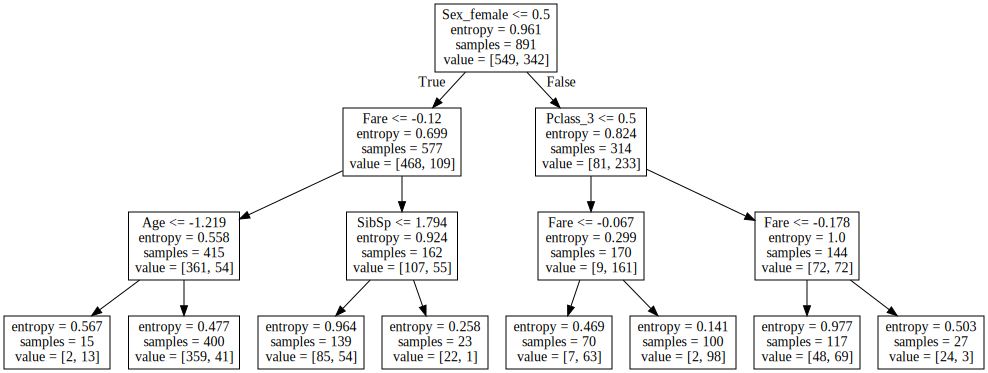

In [19]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_validate
import graphviz

tree_clf = DecisionTreeClassifier(max_depth=3, criterion="entropy", presort=True, random_state=123)
tree_clf.fit(prepped_X_train, y_train)

#cross validate model
k = 5
dt_scores = cross_validate(tree_clf, prepped_X_train, y_train, scoring=["accuracy","roc_auc"], cv=k)
acc_mean = dt_scores["test_accuracy"].mean()
acc_rng = dt_scores["test_accuracy"].max() - dt_scores["test_accuracy"].min()
auc_mean = dt_scores["test_roc_auc"].mean()
auc_rng = dt_scores["test_roc_auc"].max() - dt_scores["test_roc_auc"].min()
print(str().join([str(k), "-fold Accuracy Score Mean:"]), round(acc_mean, 5), "Range:", round(acc_rng, 5), "\n")
print(str().join([str(k), "-fold ROC AUC Score Mean:"]), round(auc_mean, 5), "Range:", round(auc_rng, 5), "\n")

#make a graph of the decision tree
dot_data = export_graphviz(tree_clf, feature_names=(num_attr + cat_encode_attr),
    out_file=None)
graph = graphviz.Source(dot_data)
graph.render(filename="DecisionTree", directory=data_path, 
    view=False, format="png")
graph

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

rf_param_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

#rf_clf = RandomForestClassifier(max_leaf_nodes=16, 
#                n_estimators=500, bootstrap=True, 
#                n_jobs=-1, oob_score=True, random_state=123)
rf_clf = RandomForestClassifier(random_state=123)
rf_rand = RandomizedSearchCV(rf_clf, param_distributions=rf_param_grid, n_iter=100, cv = k, verbose=2, random_state=123, n_jobs = -1, scoring=["accuracy","roc_auc"], refit="roc_auc")

rf_rand.fit(prepped_X_train, y_train)
acc_mean = rf_rand.cv_results_["mean_test_accuracy"].max()
auc_mean = rf_rand.cv_results_["mean_test_roc_auc"].max()
print(str().join([str(k), "-fold Accuracy Score Mean:"]), round(acc_mean, 5))
print(str().join([str(k), "-fold ROC AUC Score Mean:"]), round(auc_mean, 5))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.8min finished
5-fold Accuracy Score Mean: 0.83165
5-fold ROC AUC Score Mean: 0.87548


The results above show that the tuned random forest slightly out performed the decision tree classifier, therefore it will be used submission in the contest.

In [21]:
y_test_pred_df = pd.DataFrame(rf_rand.predict(prepped_X_test))
y_test_pred_df.columns = ["Survived"]
test_pred_df = test_df.reset_index().join(y_test_pred_df)
submit_df = test_pred_df.loc[:,["PassengerId", "Survived"]]
submit_df.to_csv(os.path.join(data_path, "submit.csv"), index=False)
